# NOXP
- Author: Hamid Ali Syed
- Date: Jun 9, 2023

In [1]:
import multiprocessing as mp
import time
import os
import glob
from matplotlib import pyplot as plt
from pyart.retrieve import get_freq_band
import numpy as np
import pyart
import warnings
warnings.filterwarnings("ignore")


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [7]:
def get_file_list(directory):
    files = []
    for root, dirs, filenames in os.walk(directory):
        for filename in filenames:
            if filename.startswith("NOX"):
                files.append(os.path.join(root, filename))
    files.sort()
    return files


def _drop_fields(radar):
    ''' Drop fields'''
    print("Dropping unnecessary fields \n")
    fields_to_drop = ['total_power', 'spectrum_width', 'specific_differential_phase']
    for field in fields_to_drop:
        if field in radar.fields:
            del radar.fields[field]
    return radar


def _align_field(field):
    values, counts = np.unique(field['data'], return_counts=True)
    c_value = values[np.argmax(counts)]
    field['data'] = np.array([c_value])
    return field


def align_radar_coords(radar):
    print("Aligning coordinates \n")
    for field_name in ['longitude', 'latitude', 'altitude', 'altitude_agl']:
        setattr(radar, field_name, _align_field(getattr(radar, field_name)))
    return radar


def mask_azimuth_jumps(radar):
    '''Mask Azimuth Jumps'''
    print("Masking azimuth jumps \n")
    az_diff = np.diff(radar.azimuth['data'])
    jumps = np.where((np.abs(az_diff) >= 10) & (np.abs(az_diff) < 359))[0]

    if len(jumps):
        for field in radar.fields.keys():
            for jump in jumps:
                radar.fields[field]['data'][jump].mask = True

    # Mask fields where azimuth is greater than 90 and less than 100
    azimuth = radar.azimuth['data']
    azimuth_mask = np.logical_and(azimuth > 92, azimuth < 125)
    for field in radar.fields.keys():
        radar.fields[field]['data'][azimuth_mask] = np.ma.masked

    return radar


def mask_data(radar, field, gatefilter):
    print(f'Masking: {field} \n')
    dsp = pyart.correct.despeckle_field(
        radar, field, gatefilter=gatefilter, size=15)
    new_field = radar.fields[field].copy()
    new_field['data'] = np.ma.masked_where(
        dsp.gate_included == False, radar.fields[field]['data'])
    radar.add_field(field, new_field, replace_existing=True)
    return radar


# function to dealiase the Doppler velocity
def dealiase(radar, vel_name='VEL_F', gatefilter=None, method="region"):
    '''
    Dealias Doppler velocities using Py-ART.
    method : str
        Method to use for the dealiasing. Can be 'unwrap' or 'region'.
    '''
    # Create a GateFilter if one was not provided
    if gatefilter is None:
        gatefilter = pyart.correct.GateFilter(radar)
    # Dealias Doppler velocities using the selected method
    if method == "unwrap":
        corr_vel = pyart.correct.dealias_unwrap_phase(radar, vel_field=vel_name,
                                                      keep_original=False, gatefilter=gatefilter)
    elif method == "region":
        corr_vel = pyart.correct.dealias_region_based(radar, vel_field=vel_name,
                                                      keep_original=False, gatefilter=gatefilter)
    # Add the dealiased Doppler velocities to the radar object
    radar.add_field(vel_name, corr_vel, replace_existing=True)
    return radar


def filter_data(radar, refl_field, refl_thresh, vel_field,
                ncp_field=None, ncp_thresh=None,
                rho_field=None, rho_thresh=None,
                dealias_method="region"):
    '''Remove noise based on velocity texture,snr, and rhohv, and mask all the fields'''

    # Align radar coords
    radar = align_radar_coords(radar)
    texture = pyart.retrieve.calculate_velocity_texture(radar,
                                                        vel_field=vel_field,
                                                        wind_size=16,
                                                        check_nyq_uniform=False)
    radar.add_field('VT', texture, replace_existing=True)
    gatefilter = pyart.filters.GateFilter(radar)
    gatefilter.include_above(refl_field, refl_thresh)
    gatefilter.include_inside(refl_field, 0, 70)
#     gatefilter.exclude_outside("PHIDP", -180, 180)
    gatefilter.exclude_outside("differential_reflectivity", -8, 8)
    gatefilter.exclude_above("VT", 20)
    
    if ncp_thresh is not None:
        gatefilter.exclude_below(ncp_field, ncp_thresh)
    else:
        pass
    
    if rho_thresh is not None:
        gatefilter.exclude_below(rho_field, rho_thresh)
    else:
        pass
    
    radar.scan_type = b'ppi'
    radar = mask_data(radar, refl_field, gatefilter)
    radar = mask_data(radar, vel_field, gatefilter)

    # Dealias
    radar = dealiase(radar, vel_name=vel_field,
                     gatefilter=gatefilter, method=dealias_method)

    mask = np.ma.getmask(radar.fields[refl_field]['data'])

    # Drop some fields
    radar = _drop_fields(radar)

    # iterate through remaining fields
    skip_fields = ["normalized_coherent_power"]
    for field in radar.fields.keys():
        if any(field == skip_field for skip_field in skip_fields):
            continue
        radar.fields[field]['data'] = np.ma.masked_where(
            mask, radar.fields[field]['data'])

    return radar


def _rename_moms(radar):
    '''Rename fields if they exist'''

    if 'DBZ' in radar.fields:
        radar.fields['REF'] = radar.fields.pop('DBZ')
    if 'reflectivity' in radar.fields:
        radar.fields['REF'] = radar.fields.pop('reflectivity')
    if 'DBZH' in radar.fields:
        radar.fields['REF'] = radar.fields.pop('DBZH')
    if 'ref' in radar.fields:
        radar.fields['REF'] = radar.fields.pop('ref')
        
    if 'VELH' in radar.fields:
        radar.fields['VEL'] = radar.fields.pop('VELH')
    if 'VEL_F' in radar.fields:
        radar.fields['VEL'] = radar.fields.pop('VEL_F')
    if 'velocity' in radar.fields:
        radar.fields['VEL'] = radar.fields.pop('velocity')
        
    if 'ZDRC' in radar.fields:
        radar.fields['ZDR'] = radar.fields.pop('ZDRC')
    if 'differential_reflectivity' in radar.fields:
        radar.fields['ZDR'] = radar.fields.pop('differential_reflectivity')
        
    if 'RHOHV' in radar.fields:
        radar.fields['RHO'] = radar.fields.pop('RHOHV')
    if 'cross_correlation_ratio' in radar.fields:
        radar.fields['RHO'] = radar.fields.pop('cross_correlation_ratio')

    return radar


def process_file(outdir, grid_file_path, rfile):
    try:
        print(f'Reading file: {os.path.basename(rfile)}')
        radar = pyart.io.read(rfile)
        refl_field = "reflectivity"
        vel_field = "velocity"
        ncp_field = "normalized_coherent_power"
        rho_field = "cross_correlation_ratio"
        refl_thresh = -5
        rho_thresh = None
        ncp_thresh = None
        radar = filter_data(radar,
                            refl_field,
                            refl_thresh,
                            vel_field,
                            ncp_field=ncp_field,
                            ncp_thresh=ncp_thresh,
                            rho_field=rho_field,
                            rho_thresh=rho_thresh,
                            dealias_method='region')

        radar = _rename_moms(radar)

        if radar.range['data'].max() <= 100e3:
            max_rng = 82750.0
            xy = 331
        else:
            max_rng = 165e3
            xy = 660

        gfields = ['REF', 'VEL', 'ZDR', "RHO"]
        grid = pyart.map.grid_from_radars(radar, (41, xy, xy),
                                          ((0., 10e3), (-max_rng, max_rng),
                                           (-max_rng, max_rng)),
                                          weighting_function='Barnes2',
                                          fields=gfields)

        print(f'Deleting Radar Object: {os.path.basename(rfile)} \n')
        del radar
        print(f"Saving in: {grid_file_path} as {os.path.basename(rfile)}\n")
        # Write grid
#         pyart.io.write_grid(filename=os.path.join(
#             grid_file_path, os.path.basename(rfile)), grid=grid)
    except Exception as e:
        print(f"Error processing file: {os.path.basename(rfile)}")
        print(str(e))


def process_file_wrapper(args):
    return process_file(*args)


# if __name__ == "__main__":
#     outdir = "/depot/dawson29/data/Projects/PERiLS/obsdata/2022/GRID/IOP2/"
#     basedir = "/depot/dawson29/data/Projects/PERiLS/obsdata/2022/Illinois_Mobile_Radar/IOP2/"

# #     # First directory (DOW8)
# #     dow8_dir = os.path.join(basedir, "DOW8/merged/")
# #     file_list_dow8 = get_file_list(dow8_dir)
# #     num_files_dow8 = len(file_list_dow8)
# #     print("Number of files in DOW8 directory:", num_files_dow8)
# #     grid_file_path_dow8 = os.path.join(outdir, "DOW8")
# #     os.makedirs(grid_file_path_dow8, exist_ok=True)

#     # Second directory (DOW7)
#     dow7_dir = os.path.join(basedir, "DOW7/merged/")
#     file_list_dow7 = get_file_list(dow7_dir)
#     num_files_dow7 = len(file_list_dow7)
#     print("Number of files in DOW7 directory:", num_files_dow7)
#     grid_file_path_dow7 = os.path.join(outdir, "DOW7")
#     os.makedirs(grid_file_path_dow7, exist_ok=True)

# #     # Create a pool of worker processes for DOW8
# #     pool_dow8 = mp.Pool()
# #     results_dow8 = pool_dow8.map(process_file_wrapper, [(outdir, grid_file_path_dow8, f) for f in file_list_dow8])
# #     pool_dow8.close()
# #     pool_dow8.join()

#     # Create a pool of worker processes for DOW7
#     pool_dow7 = mp.Pool()
#     results_dow7 = pool_dow7.map(process_file_wrapper, [(outdir, grid_file_path_dow7, f) for f in file_list_dow7])
#     pool_dow7.close()
#     pool_dow7.join()

In [52]:
basedir = "/depot/dawson29/data/Projects/PERiLS/obsdata/2022/NOXP/"
file_list = get_file_list(basedir)

In [53]:
len(file_list)

202

In [54]:
os.path.basename(file_list)

'NOX220330225418.nc'

In [11]:
radar = pyart.io.read_sigmet(file_list[100])
radar.fields.keys()

dict_keys(['total_power', 'reflectivity', 'velocity', 'spectrum_width', 'differential_reflectivity', 'specific_differential_phase', 'differential_phase', 'normalized_coherent_power', 'cross_correlation_ratio'])

In [12]:
print(radar.range['data'].max()/1e3)

76.425


In [46]:
basedir = "/depot/dawson29/data/Projects/PERiLS/obsdata/2022/NOXP/"
file_list = get_file_list(basedir)

In [49]:
from NOXP_raw_to_cfrad_grid import process_file

In [ ]:
outdir = "/depot/dawson29/data/Projects/PERiLS/obsdata/2022/GRID/IOP2/"

process_file(outdir, grid_file_path, CFRAD_DIR, rfile)

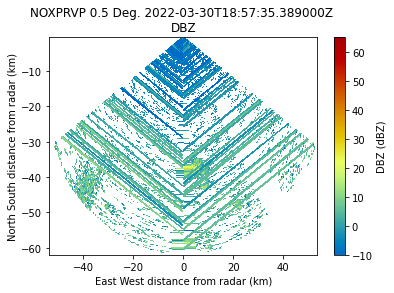

In [38]:
# radar.fields.keys()
display = pyart.graph.RadarDisplay(radar)
display.plot_ppi("DBZ")

In [16]:
def linspace_range(start, stop, step):
    num = np.floor((stop - start) / step + 1)
    num-=1
    return int(num), num*step/2

max_range = radar.range['data'].max()
xy, rng  = linspace_range(-max_range, max_range, 500)
xy, rng

(305, 76250.0)

In [17]:
radar.range['data'].max()

76425.0

In [15]:
xy, rng  = linspace_range(-max_range, max_range, 500)
xy, rng

(331, 82750.0)

In [335]:
radar.fields.keys()

dict_keys(['DBZ_TOT', 'DBZ', 'VEL', 'WIDTH', 'ZDR', 'KDP', 'PHIDP', 'SQI', 'RHOHV'])

In [328]:
import os
import shutil
import xarray as xr

range_issue_dir = os.path.join(smart_r2, "range_issue")
if not os.path.exists(range_issue_dir):
    os.makedirs(range_issue_dir)

ranges = []
for file in file_list:
    ds = xr.open_dataset(file)
    rng = ds.range.max().values
    if rng < 50000.0:
        print(file)
        filename = os.path.basename(file)
        destination = os.path.join(range_issue_dir, filename)
        shutil.move(file, destination)
    ranges.append(rng)

/depot/dawson29/data/Projects/PERiLS/obsdata/2022/SMART/SMARTR2/cfrad.20220331_022229.947_to_20220331_022329.957_SR2_VER.nc
/depot/dawson29/data/Projects/PERiLS/obsdata/2022/SMART/SMARTR2/cfrad.20220331_022331.044_to_20220331_022431.055_SR2_VER.nc
/depot/dawson29/data/Projects/PERiLS/obsdata/2022/SMART/SMARTR2/cfrad.20220331_022432.223_to_20220331_022532.230_SR2_VER.nc
/depot/dawson29/data/Projects/PERiLS/obsdata/2022/SMART/SMARTR2/cfrad.20220331_022533.402_to_20220331_022633.411_SR2_VER.nc
/depot/dawson29/data/Projects/PERiLS/obsdata/2022/SMART/SMARTR2/cfrad.20220331_022634.492_to_20220331_022734.505_SR2_VER.nc


In [329]:
np.unique(ranges)

array([ 30000.,  82950., 165000.])

In [330]:
!ls $range_issue_dir

cfrad.20220331_022229.947_to_20220331_022329.957_SR2_VER.nc
cfrad.20220331_022331.044_to_20220331_022431.055_SR2_VER.nc
cfrad.20220331_022432.223_to_20220331_022532.230_SR2_VER.nc
cfrad.20220331_022533.402_to_20220331_022633.411_SR2_VER.nc
cfrad.20220331_022634.492_to_20220331_022734.505_SR2_VER.nc


In [337]:
660 * 500/2

165000.0

In [339]:
165e3

165000.0

In [1]:
!cat sbatch_parallel_gridding.sbatch

#!/bin/sh -l
# FILENAME:  gridding2

#SBATCH -A dawson29

#SBATCH -o /home/syed44/PERiLS/doppler_analysis/gridding/parallel_gridding.out

#SBATCH --nodes=1
#SBATCH -c 128
#SBATCH --time=03:00:00
#SBATCH --mail-user=syed44@purdue.edu
#SBATCH --mail-type=BEGIN,END


# Print the hostname of the compute node on which this job is running.
/bin/hostname


module use /depot/dawson29/data/Projects/PERiLS/etc/modules/
module load conda-env/perils-py3.8.5

python /home/syed44/PERiLS/doppler_analysis/gridding/NOXP_raw_to_cfrad_grid.py

In [111]:
import subprocess

sbatch_command = "sbatch sbatch_parallel_gridding.sbatch"
output = subprocess.check_output(sbatch_command, shell=True)
job_id = output.decode('utf-8').strip().split()[-1]

print("Submitted job with ID:", job_id)

Submitted job with ID: 25774864


In [136]:
!squeue -A dawson29

JOBID        USER      ACCOUNT      NAME             NODES   CPUS  TIME_LIMIT ST TIME
25769979     syed44    dawson29     OnDemand/Noteboo     1     16  5-00:00:00  R 5:45:38
25706197     kaxon     dawson29     OnDemand/Desktop     1      4  2-12:00:00  R 2-06:52:53
25774864     syed44    dawson29     sbatch_parallel_     1    128     3:00:00  R 48:41


In [141]:
!tail parallel_gridding.out

## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119

Number of NOXP files: 202


In [138]:
outdir = "/depot/dawson29/data/Projects/PERiLS/obsdata/2022/GRID/IOP2/"
basedir = "/depot/dawson29/data/Projects/PERiLS/obsdata/2022/NOXP/"

In [143]:
ls -lth $outdir/NOXP | wc

    198    1775   13997


In [144]:
ls -lth $basedir/cfrad | wc

    198    1775   13997


In [145]:
ls -lth $outdir/NOXP

total 13G
-rw-rw---- 1 syed44 dawson29-data  24M Jun 10 20:14 NOX220330195317.nc
-rw-rw---- 1 syed44 dawson29-data  24M Jun 10 20:08 NOX220330193212.nc
-rw-rw---- 1 syed44 dawson29-data  24M Jun 10 19:56 NOX220330194903.nc
-rw-rw---- 1 syed44 dawson29-data  24M Jun 10 19:54 NOX220330194403.nc
-rw-rw---- 1 syed44 dawson29-data  24M Jun 10 19:52 NOX220330192758.nc
-rw-rw---- 1 syed44 dawson29-data  35M Jun 10 18:57 NOX220330223202.nc
-rw-rw---- 1 syed44 dawson29-data  35M Jun 10 18:57 NOX220330222738.nc
-rw-rw---- 1 syed44 dawson29-data  37M Jun 10 18:57 NOX220331020202.nc
-rw-rw---- 1 syed44 dawson29-data  38M Jun 10 18:56 NOX220330213732.nc
-rw-rw---- 1 syed44 dawson29-data  39M Jun 10 18:56 NOX220330204202.nc
-rw-rw---- 1 syed44 dawson29-data  39M Jun 10 18:56 NOX220330202216.nc
-rw-rw---- 1 syed44 dawson29-data  35M Jun 10 18:56 NOX220330224202.nc
-rw-rw---- 1 syed44 dawson29-data  39M Jun 10 18:55 NOX220330203201.nc
-rw-rw---- 1 syed44 dawson29-data  38M Jun 10 18:55 NOX220330213202

In [33]:
# import xarray as xr
# ds = xr.open_dataset(basedir+'/wdssii/Reflectivity/00.50/20220330-185731.netcdf')

In [34]:
# ds#['Reflectivity']

In [64]:
def mask_azimuth_jumps(radar):
    '''Mask Azimuth Jumps'''
    print("Masking azimuth jumps \n")
    az_diff = np.diff(radar.azimuth['data'])
    jumps = np.where((np.abs(az_diff) >= 10) & (np.abs(az_diff) < 359))[0]

    if len(jumps):
        for field in radar.fields.keys():
            for jump in jumps:
                radar.fields[field]['data'][jump].mask = True

    # Mask fields where azimuth is greater than 90 and less than 100
    azimuth = radar.azimuth['data']
    azimuth_mask = np.logical_and(azimuth > 92, azimuth < 125)
    for field in radar.fields.keys():
        radar.fields[field]['data'][azimuth_mask] = np.ma.masked

    return radar

In [65]:
radar = mask_azimuth_jumps(radar)

Masking azimuth jumps 



In [13]:
radar = pyart.io.read(file_list[88])
az_diff = np.diff(radar.azimuth['data'])
jumps = np.where((np.abs(az_diff) >= 10) & (np.abs(az_diff) < 359))[0]

In [15]:
file_list[88]

'/depot/dawson29/data/Projects/PERiLS/obsdata/2022/NOXP/NOX220330223202.RAWC1YC'

In [16]:
radar = pyart.io.read_sigmet(file_list[88])

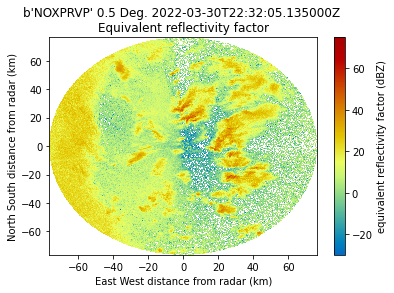

In [17]:
# radar.fields.keys()
display = pyart.graph.RadarDisplay(radar)
display.plot_ppi("reflectivity")

In [20]:
radar.range['data'].max()

76425.0

In [91]:
radar.fixed_angle

{'long_name': 'Target angle for sweep',
 'units': 'degrees',
 'standard_name': 'target_fixed_angle',
 'data': array([ 0.49987793,  1.1975098 ,  1.9006348 ,  2.5982666 ,  3.4002686 ,
         4.2022705 ,  7.998047  , 10.997314  , 14.002075  ], dtype=float32)}

In [ ]:
sweeps = []
ranges = []
for file in file_list:
    radar = pyart.io.read_sigmet(file)
    if radar.nsweeps > 3:
#         print(f'Sweeps: {radar.nsweeps}, {radar.range["data"].max()} \n')
        sweeps.append(radar.nsweeps)
        ranges.append(radar.range["data"].max())
    else: continue

In [60]:
import multiprocessing as mp
import time
import os
import glob
from matplotlib import pyplot as plt
import numpy as np
import pyart
import warnings
warnings.filterwarnings("ignore")


def get_file_list(directory):
    files = []
    for root, dirs, filenames in os.walk(directory):
        for filename in filenames:
            if filename.startswith("NOX"):
                files.append(os.path.join(root, filename))
    files.sort()
    return files


def _align_field(field):
    values, counts = np.unique(field['data'], return_counts=True)
    c_value = values[np.argmax(counts)]
    field['data'] = np.array([c_value])
    return field


def align_radar_coords(radar):
    print("Aligning coordinates \n")
    for field_name in ['longitude', 'latitude', 'altitude', 'altitude_agl']:
        setattr(radar, field_name, _align_field(getattr(radar, field_name)))
    return radar

def mask_data(radar, field, gatefilter):
    print(f'Masking: {field} \n')
    dsp = pyart.correct.despeckle_field(
        radar, field, gatefilter=gatefilter, size=15)
    new_field = radar.fields[field].copy()
    new_field['data'] = np.ma.masked_where(
        dsp.gate_included == False, radar.fields[field]['data'])
    radar.add_field(field, new_field, replace_existing=True)
    return radar


# function to dealiase the Doppler velocity
def dealiase(radar, vel_name='VEL_F', gatefilter=None, method="region"):
    '''
    Dealias Doppler velocities using Py-ART.
    method : str
        Method to use for the dealiasing. Can be 'unwrap' or 'region'.
    '''
    # Create a GateFilter if one was not provided
    if gatefilter is None:
        gatefilter = pyart.correct.GateFilter(radar)
    # Dealias Doppler velocities using the selected method
    if method == "unwrap":
        corr_vel = pyart.correct.dealias_unwrap_phase(radar, vel_field=vel_name,
                                                      keep_original=False, gatefilter=gatefilter)
    elif method == "region":
        corr_vel = pyart.correct.dealias_region_based(radar, vel_field=vel_name,
                                                      keep_original=False, gatefilter=gatefilter)
    # Add the dealiased Doppler velocities to the radar object
    radar.add_field(vel_name, corr_vel, replace_existing=True)
    return radar


def filter_data(radar, refl_field, refl_thresh, vel_field,
                ncp_field=None, ncp_thresh=None,
                rho_field=None, rho_thresh=None,
                dealias_method="region"):
    '''Remove noise based on velocity texture,snr, and rhohv, and mask all the fields'''

    # Align radar coords
#     radar = align_radar_coords(radar)
    texture = pyart.retrieve.calculate_velocity_texture(radar,
                                                        vel_field=vel_field,
                                                        wind_size=16,
                                                        check_nyq_uniform=False)
    radar.add_field('VT', texture, replace_existing=True)
    gatefilter = pyart.filters.GateFilter(radar)
    gatefilter.include_above(refl_field, refl_thresh)
    gatefilter.include_inside(refl_field, 0, 70)
#     gatefilter.exclude_outside("PHIDP", -180, 180)
    gatefilter.exclude_outside("differential_reflectivity", -8, 8)
    gatefilter.exclude_above("VT", 20)
    
    if ncp_thresh is not None:
        gatefilter.exclude_below(ncp_field, ncp_thresh)
    else:
        pass
    
    if rho_thresh is not None:
        gatefilter.exclude_below(rho_field, rho_thresh)
    else:
        pass
    
    radar.scan_type = b'ppi'
    radar = mask_data(radar, refl_field, gatefilter)
    radar = mask_data(radar, vel_field, gatefilter)

    # Dealias
    radar = dealiase(radar, vel_name=vel_field,
                     gatefilter=gatefilter, method=dealias_method)

    mask = np.ma.getmask(radar.fields[refl_field]['data'])

    # Drop some fields
    radar = _drop_fields(radar)

    # iterate through remaining fields
    skip_fields = ["normalized_coherent_power"]
    for field in radar.fields.keys():
        if any(field == skip_field for skip_field in skip_fields):
            continue
        radar.fields[field]['data'] = np.ma.masked_where(
            mask, radar.fields[field]['data'])

    return radar


def _rename_moms(radar):
    '''Rename fields if they exist'''

    if 'DBZ' in radar.fields:
        radar.fields['REF'] = radar.fields.pop('DBZ')
    if 'reflectivity' in radar.fields:
        radar.fields['REF'] = radar.fields.pop('reflectivity')
    if 'DBZH' in radar.fields:
        radar.fields['REF'] = radar.fields.pop('DBZH')
    if 'ref' in radar.fields:
        radar.fields['REF'] = radar.fields.pop('ref')
        
    if 'VELH' in radar.fields:
        radar.fields['VEL'] = radar.fields.pop('VELH')
    if 'VEL_F' in radar.fields:
        radar.fields['VEL'] = radar.fields.pop('VEL_F')
    if 'velocity' in radar.fields:
        radar.fields['VEL'] = radar.fields.pop('velocity')
        
    if 'ZDRC' in radar.fields:
        radar.fields['ZDR'] = radar.fields.pop('ZDRC')
    if 'differential_reflectivity' in radar.fields:
        radar.fields['ZDR'] = radar.fields.pop('differential_reflectivity')
        
    if 'RHOHV' in radar.fields:
        radar.fields['RHO'] = radar.fields.pop('RHOHV')
    if 'cross_correlation_ratio' in radar.fields:
        radar.fields['RHO'] = radar.fields.pop('cross_correlation_ratio')

    return radar


def linspace_range(start, stop, step):
    num = np.floor((stop - start) / step + 1)
    num-=1
    return int(num), num*step/2


def process_file(outdir, grid_file_path, CFRAD_DIR, rfile):
    try:
        print(f'Reading file: {os.path.basename(rfile)}')
        radar = pyart.io.read_sigmet(rfile)
        if radar.nsweeps > 3:
            refl_field = "reflectivity"
            vel_field = "velocity"
            ncp_field = "normalized_coherent_power"
            rho_field = "cross_correlation_ratio"
            refl_thresh = -5
            rho_thresh = None
            ncp_thresh = None
            radar = filter_data(radar,
                                refl_field,
                                refl_thresh,
                                vel_field,
                                ncp_field=ncp_field,
                                ncp_thresh=ncp_thresh,
                                rho_field=rho_field,
                                rho_thresh=rho_thresh,
                                dealias_method='region')
            
            print(f'Saving Cfradial in {CFRAD_DIR} as {os.path.basename(rfile).split(".RAW")[0]+".nc"}')
            cffile = os.path.join(CFRAD_DIR, os.path.basename(rfile).split(".RAW")[0]+".nc")
#             pyart.io.write_cfradial(filename=cffile, radar=radar)
            
            radar = _rename_moms(radar)

            max_range = radar.range['data'].max()
            xy, rng = linspace_range(-max_range, max_range, 500)

            gfields = ['REF', 'VEL', 'ZDR', "RHO"]
#             grid = pyart.map.grid_from_radars(radar, (41, xy, xy),
#                                               ((0., 10e3), (-rng, rng),
#                                                (-rng, rng)),
#                                               weighting_function='Barnes2',
#                                               fields=gfields)
            del radar
            print(f'Saving in {grid_file_path} as {os.path.basename(rfile).split(".RAW")[0]+".nc"}')
            # Write grid
#             pyart.io.write_grid(filename=os.path.join(
#                 grid_file_path, os.path.basename(rfile).split(".RAW")[0]+".nc"), grid=grid)
        else:
            print(f'Not enough sweeps in {os.path.basename(rfile)} to process.')
    except Exception as e:
        print(f"Error processing file: {os.path.basename(rfile)}")
        print(str(e))


def process_file_wrapper(args):
    return process_file(*args)

In [57]:
radar = pyart.io.read_sigmet(file_list[134])

In [59]:
radar.longitude, radar.latitude

({'long_name': 'Longitude',
  'standard_name': 'Longitude',
  'units': 'degrees_east',
  'data': array([-88.49521637])},
 {'long_name': 'Latitude',
  'standard_name': 'Latitude',
  'units': 'degrees_north',
  'data': array([33.13253403])})